In [2]:
# Traffic prediction_length is 24. Reference:
# https://github.com/awslabs/gluonts/blob/6605ab1278b6bf92d5e47343efcf0d22bc50b2ec/src/gluonts/dataset/repository/_lstnet.py#L105

prediction_length = 24
context_length = prediction_length*2
batch_size = 128
num_batches_per_epoch = 100
epochs = 50
scaling = "std"

The transformers models are all relatively small with:


In [3]:
encoder_layers=2
decoder_layers=2
d_model=16

Instead of showing how to train a model using `Autoformer`, one can just replace the model in the previous two blog posts ([TimeSeriesTransformer](https://huggingface.co/blog/time-series-transformers) and [Informer](https://huggingface.co/blog/informer)) with the new `Autoformer` model and train it on the `traffic` dataset. In order to not repeat ourselves, we have already trained the models and pushed them to the HuggingFace Hub. We will use those models for evaluation.

## Load Dataset

Let's first install the necessary libraries:

In [4]:
!pip install -q transformers datasets evaluate accelerate "gluonts[torch]" ujson tqdm
!pip install -q protobuf --upgrade # without it, the evaluation code fails

^C


ERROR: Invalid requirement: '#'


The `traffic` dataset, used by [Lai et al. (2017)](https://arxiv.org/abs/1703.07015), contains the San Francisco Traffic. It contains 862 hourly time series showing the road occupancy rates in the range \\([0, 1]\\) on the San Francisco Bay Area freeways from 2015 to 2016.

In [2]:
from gluonts.dataset.repository.datasets import get_dataset

dataset = get_dataset("traffic")
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length
print(f"traffic dataset prediction_length: {prediction_length}")
print(freq)

traffic dataset prediction_length: 24
H


In [6]:
dataset.train['target']

TypeError: 'Map' object is not subscriptable

python -u run.py  --is_training 1 --root_path ./datasets/ --data_path data_step=60.csv --model_id qber1   --model Autoformer   --data custom   --features M   --seq_len 96 --label_len 48 --pred_len 336 --e_layers 2 --d_layers 1 --factor 3 --enc_in 6 --dec_in 6 --c_out 6 --des 'Exp' --itr 1  --train_epochs 3 --moving_avg 25 --use_gpu 1 --batch_size 64

Let's visualize a time series in the dataset and plot the train/test split:

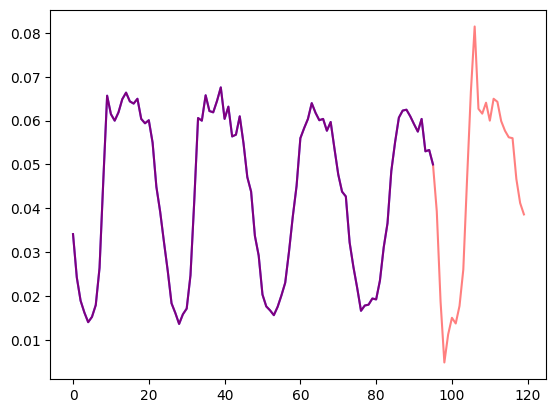

In [7]:
import matplotlib.pyplot as plt

train_example = next(iter(dataset.train))
test_example = next(iter(dataset.test))

num_of_samples = 4*prediction_length

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    test_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

In [8]:
train_dataset = dataset.train
test_dataset = dataset.test

In [10]:
from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create a list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset (as, remember, we can't pass the entire history of values to the model due to time and memory constraints).

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys for the respective windows. This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively. The same happens for any keys in the `time_series_fields` argument:


In [11]:
from gluonts.transform import InstanceSplitter
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create PyTorch DataLoaders

Next, it's time to create PyTorch DataLoaders, which allow us to have batches of (input, output) pairs - or in other words (`past_values`, `future_values`).


In [12]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [13]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

## Evaluate on Autoformer

We have already pre-trained an Autoformer model on this dataset, so we can just fetch the model and evaluate it on the test set:


In [14]:
from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig.from_pretrained("kashif/autoformer-traffic-hourly")
model = AutoformerForPrediction.from_pretrained("kashif/autoformer-traffic-hourly")

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

At inference time, we will use the model's `generate()` method for predicting `prediction_length` steps into the future from the very last context window of each time series in the training set.


In [15]:
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
model.to(device)
model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`, `input_size`).

In this case, we get `100` possible values for the next `24` hours for each of the  time series in the test dataloader batch which if you recall from above is `64`:


In [16]:
forecasts_[0].shape

(64, 100, 24)

We'll stack them vertically, to get forecasts for all time-series in the test dataset: We have `7` rolling windows in the test set which is why we end up with a total of `7 * 862 = 6034` predictions:


In [17]:
import numpy as np

forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(6034, 100, 24)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) metrics.

We calculate the metric for each time series in the dataset and return the average:


In [18]:
from tqdm.autonotebook import tqdm
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
for item_id, ts in enumerate(tqdm(test_dataset)):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])

  0%|          | 0/6034 [00:00<?, ?it/s]

So the result for the Autoformer model is:


In [19]:
print(f"Autoformer univariate MASE: {np.mean(mase_metrics):.3f}")

Autoformer univariate MASE: 0.910


To plot the prediction for any time series with respect to the ground truth test data, we define the following helper:

In [20]:
import matplotlib.dates as mdates
import pandas as pd

test_ds = list(test_dataset)

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_ds[ts_index][FieldName.START],
        periods=len(test_ds[ts_index][FieldName.TARGET]),
        freq=test_ds[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.plot(
        index[-5*prediction_length:],
        test_ds[ts_index]["target"][-5*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.gcf().autofmt_xdate()
    plt.legend(loc="best")
    plt.show()

For example, for time-series in the test set with index `4`:

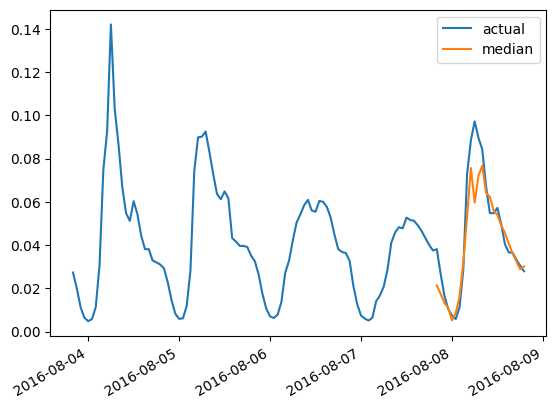

In [24]:
plot(1)

## Evaluate on DLinear

A probabilistic DLinear is implemented in `gluonts` and thus we can train and evaluate it relatively quickly here:


In [ ]:
from gluonts.torch.model.d_linear.estimator import DLinearEstimator

# Define the DLinear model with the same parameters as the Autoformer model
estimator = DLinearEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    scaling=scaling,
    hidden_dimension=2,

    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    trainer_kwargs=dict(max_epochs=epochs)
)

Train the model:


In [ ]:
predictor = estimator.train(
    training_data=train_dataset,
    cache_data=True,
    shuffle_buffer_length=1024
)

And evaluate it on the test set:

In [ ]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

d_linear_forecasts = list(forecast_it)
d_linear_tss = list(ts_it)

evaluator = Evaluator()

agg_metrics, _ = evaluator(iter(d_linear_tss), iter(d_linear_forecasts))

Running evaluation: 6034it [00:00, 132667.41it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


So the result for the DLinear model is:

In [ ]:
dlinear_mase = agg_metrics["MASE"]
print(f"DLinear MASE: {dlinear_mase:.3f}")

DLinear MASE: 0.965


As before, we plot the predictions from our trained DLinear model via this helper:

In [ ]:
def plot_gluonts(index):
    plt.plot(d_linear_tss[index][-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    d_linear_forecasts[index].plot(show_label=True,  color='g')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

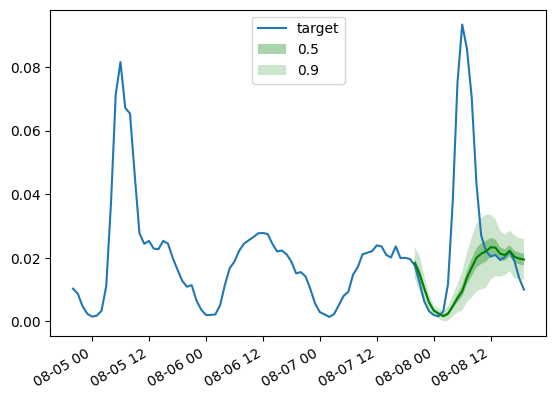

In [ ]:
plot_gluonts(4)